In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython import display
import pickle

import matplotlib.pyplot as plt
import torch
from torchinfo import summary

from src.configs import FastSpeech2Config
from src.data_utils import Wav2Spec
from src.models import FastSpeech
from src.vocoders import WaveGlow

In [3]:
BATCH_PATH = 'checkpoints/overfitted/batch.pkl'
MODEL_PATH = 'checkpoints/overfitted/model.pth'

INDEX = 1

In [4]:
config = FastSpeech2Config()
fs = FastSpeech(config)
fs.load_state_dict(torch.load(MODEL_PATH, map_location=config.device))
summary(fs)

Layer (type:depth-idx)                             Param #
FastSpeech                                         --
├─Embedding: 1-1                                   9,728
├─PositionalEncoding1D: 1-2                        --
├─Sequential: 1-3                                  --
│    └─FFTBlock: 2-1                               --
│    │    └─Sequential: 3-1                        2,886,912
│    └─FFTBlock: 2-2                               --
│    │    └─Sequential: 3-2                        2,886,912
│    └─FFTBlock: 2-3                               --
│    │    └─Sequential: 3-3                        2,886,912
│    └─FFTBlock: 2-4                               --
│    │    └─Sequential: 3-4                        2,886,912
├─LengthRegulator: 1-4                             --
│    └─DurationPredictor: 2-5                      --
│    │    └─Sequential: 3-5                        395,009
├─Sequential: 1-5                                  --
│    └─FFTBlock: 2-6                     

In [5]:
with open(BATCH_PATH, 'rb') as f:
    batch = pickle.load(f)

In [6]:
wav = batch.waveform[INDEX, :batch.waveform_length[INDEX]]
display.Audio(wav, rate=config.sample_rate)

In [7]:
wav2spec = Wav2Spec(config)

In [8]:
gt_spec = wav2spec(wav)

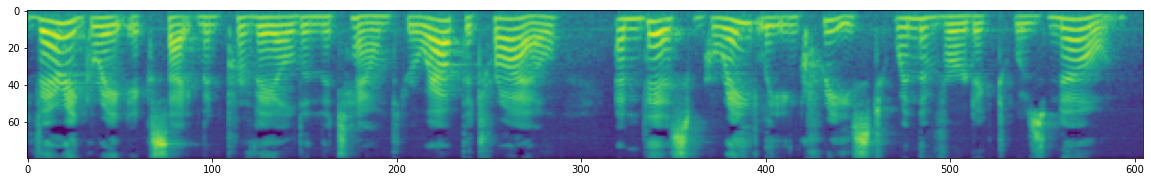

In [9]:
_ = plt.figure(figsize=(20, 10))
_ = plt.imshow(gt_spec)

In [10]:
with torch.no_grad():
    spec = fs(batch.tokens[INDEX, :batch.token_lengths[INDEX]].unsqueeze(0)).squeeze()

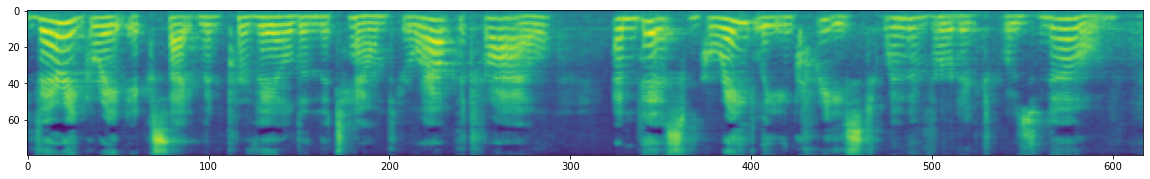

In [11]:
_ = plt.figure(figsize=(20, 10))
_ = plt.imshow(spec)

Как мы видим, спектрограммы довольно похожи. Хочу отметить, что своей модели я во время inference-a не подавал длительности графем, т.е. duration predictor тоже обучился.

In [13]:
# !git clone https://github.com/NVIDIA/waveglow.git

In [14]:
import sys
sys.path.append('waveglow/')
vocoder = WaveGlow(config.device)

/home/jupyter/.local/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter/.local/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter/.local/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing th

Послушаем получившиеся wav-ки, сначала правильную, потом мою:

In [15]:
wav = vocoder.inference(gt_spec.unsqueeze(0))
display.Audio(wav, rate=config.sample_rate)

In [16]:
wav = vocoder.inference(spec.unsqueeze(0))
display.Audio(wav, rate=config.sample_rate)